In [12]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [13]:
#hide
from fastbook import *

## From Dogs and Cats to Pet Breeds

In [14]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [15]:
Path.BASE_PATH = path

In [16]:
path.ls()

(#2) [Path('images'),Path('annotations')]

We can see that this dataset provides us with *images* and *annotations* directories. The [website](https://www.robots.ox.ac.uk/~vgg/data/pets/) for the dataset tells us that the *annotations* directory contains information about where the pets are rather than what they are. In this chapter, we will be doing classification, not localization, which is to say that we care about what the pets are, not where they are. Therefore, we will ignore the *annotations* directory for now. So, let's have a look inside the *images* directory:

In [17]:
(path/"images").ls()

(#7393) [Path('images/miniature_pinscher_199.jpg'),Path('images/newfoundland_183.jpg'),Path('images/pomeranian_90.jpg'),Path('images/pomeranian_102.jpg'),Path('images/japanese_chin_74.jpg'),Path('images/yorkshire_terrier_45.jpg'),Path('images/chihuahua_34.jpg'),Path('images/american_pit_bull_terrier_150.jpg'),Path('images/wheaten_terrier_160.jpg'),Path('images/staffordshire_bull_terrier_91.jpg')...]

Most functions and methods in fastai that return a collection use a class called `L`. `L` can be thought of as an enhanced version of the ordinary Python `list` type, with added conveniences for common operations. For instance, when we display an object of this class in a notebook it appears in the format shown there. The first thing that is shown is the number of items in the collection, prefixed with a `#`.

In [18]:
fname = (path/"images").ls()[0]

In [19]:
fname

Path('images/miniature_pinscher_199.jpg')

In [20]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['miniature_pinscher']

In [23]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  splitter = RandomSplitter(seed=42),
                  get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                  item_tfms = Resize(460),
                  batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [24]:
# random resize crop

# Presizing
To overcome challenges coming from data augmentations, presizing adopts to strategies:
- resize images to relatively "large" dimensions - that is, dimensions significantly larger than the target training dimensions
- compose all of the common augmentation operations (including a resize to the final target size) into one, and perform the combined operation on the GPU only once at the end of processing, rather than performing the operations individually and interpolating multiple images

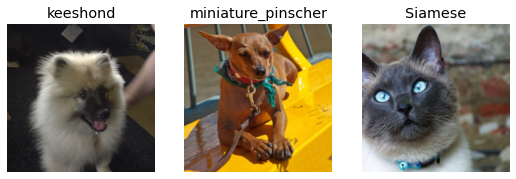

In [25]:
dls.show_batch(nrows=1, ncols=3)

In [28]:
learn = vision_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.490911,0.364237,0.111637,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.529728,0.290798,0.090663,00:39
1,0.343521,0.221808,0.071719,00:39


# Cross-Entropy Loss
it's a loss function similar to the one we used before, but has two benefits:
- it works event when our dependent variable has more than two categories
- it results in faster and more reliable training

In [33]:
x, y = dls.one_batch()

In [38]:
len(y) # def batch size, each row is a single int between 0 and 36 repersenting our 37 possible pet breeds

64

In [41]:
preds, _ = learn.get_preds(dl=[(x,y)])

In [43]:
len(preds[0]), preds[0].sum()

(37, TensorBase(1.0000))

# Softmax
What does this function do in practice? Taking the exponential ensures all our numbers are positive, and then dividing by the sum ensures we are going to have a bunch of numbers that add up to 1. The exponential also has a nice property: if one of the numbers in our activations x is slightly bigger than the others, the exponential will amplify this (since it grows, well... exponentially), which means that in the softmax, that number will be closer to 1.

Intuitively, the softmax function really wants to pick one class among the others, so it's ideal for training a classifier when we know each picture has a definite label. (Note that it may be less ideal during inference, as you might want your model to sometimes tell you it doesn't recognize any of the classes that it has seen during training, and not pick a class because it has a slightly bigger activation score. In this case, it might be better to train a model using multiple binary output columns, each using a sigmoid activation.)

In [44]:
def softmax(x):
    return exp(x) / exp(x).sum(dim=1, keepdim=True)

In [49]:
torch.random.manual_seed(42)
acts = torch.randn((6,2))*2

In [50]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [51]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

Softmax is the first part of the cross-entropy loss—the second part is log likelihood.

In [52]:
targ = tensor([0, 1, 0,1,1,0])

In [53]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [54]:
idx = range(6)

In [55]:
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [56]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]
t = df.style.hide_index()
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,result
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [57]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

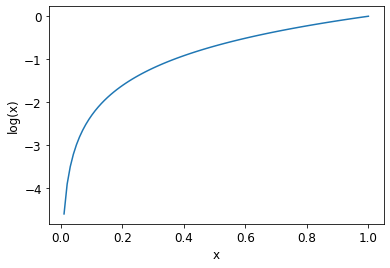

In [64]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

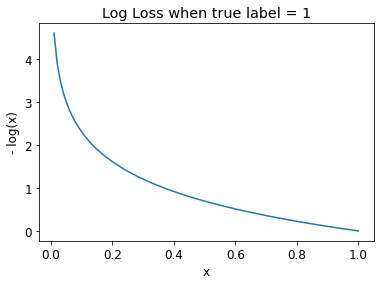

In [65]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

In [66]:
from IPython.display import HTML
df['loss'] = -torch.log(tensor(df['result']))
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,result,loss
0.602469,0.397531,0,0,0.602469,0.506720
0.502065,0.497935,1,1,0.497935,0.697285
0.133188,0.866811,0,2,0.133188,2.015990
0.996640,0.003360,1,3,0.003360,5.695763
0.595949,0.404051,1,4,0.404051,0.906213
0.366118,0.633882,0,5,0.366118,1.004798


In [67]:
loss_func = nn.CrossEntropyLoss()

In [68]:
loss_func(acts, targ)

tensor(1.8045)

In [69]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [70]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

s: An interesting feature about cross-entropy loss appears when we consider its gradient. The gradient of cross_entropy(a,b) is just softmax(a)-b. Since softmax(a) is just the final activation of the model, that means that the gradient is proportional to the difference between the prediction and the target. This is the same as mean squared error in regression (assuming there's no final activation function such as that added by y_range), since the gradient of (a-b)**2 is 2*(a-b). Because the gradient is linear, that means we won't see sudden jumps or exponential increases in gradients, which should lead to smoother training of models.

# Model Interpretation

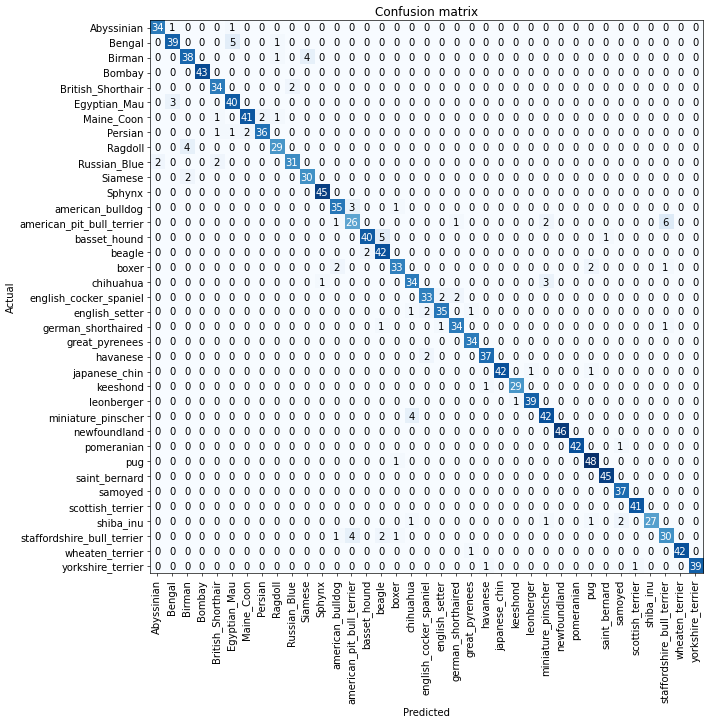

In [71]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [72]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('basset_hound', 'beagle', 5)]

# The Learning Rate Finder

What do we do to find the perfect learning rate—not too high, and not too low? In 2015 the researcher Leslie Smith came up with a brilliant idea, called the learning rate finder. His idea was to start with a very, very small learning rate, something so small that we would never expect it to be too big to handle. We use that for one mini-batch, find what the losses are afterwards, and then increase the learning rate by some percentage (e.g., doubling it each time). Then we do another mini-batch, track the loss, and double the learning rate again. We keep doing this until the loss gets worse, instead of better. This is the point where we know we have gone too far. We then select a learning rate a bit lower than this point. Our advice is to pick either:

One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
The last point where the loss was clearly decreasing


In [73]:
learn = vision_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.839234,6.263300,0.569012,00:31


epoch,train_loss,valid_loss,error_rate,time
0,3.972814,3.660971,0.743572,00:38


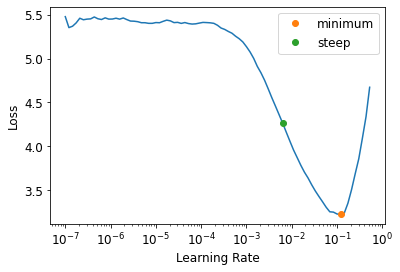

In [74]:
learn = vision_learner(dls, resnet34, metrics = error_rate)
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [75]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 6.31e-03


In [76]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.321204,0.371387,0.112314,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.533383,0.377764,0.115697,00:38
1,0.332310,0.235547,0.076455,00:39


In [77]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py
Type:      method


In [78]:
learn = vision_learner(dls, resnet34, metrics = error_rate)

In [79]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.134262,0.354943,0.103518,00:30
1,0.526691,0.259391,0.078484,00:30
2,0.318252,0.230167,0.070365,00:31


In [80]:
learn.unfreeze()

SuggestedLRs(valley=7.585775892948732e-05)

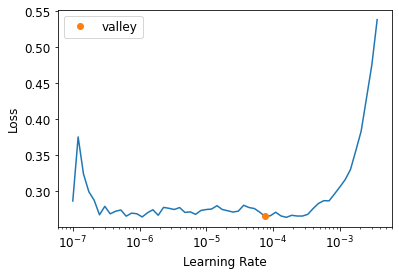

In [81]:
learn.lr_find()

In [82]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.261520,0.220659,0.066982,00:38
1,0.246066,0.217245,0.066306,00:38
2,0.220022,0.207321,0.065629,00:38
3,0.209436,0.206839,0.063599,00:38
4,0.191399,0.204902,0.062923,00:38
5,0.181046,0.203735,0.064276,00:38


# Discriminative Learning Rates
fastai's default approach is to use discriminative learning rates. This was originally developed in the ULMFiT approach to NLP transfer learning that we will introduce in <>. Like many good ideas in deep learning, it is extremely simple: use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers). The idea is based on insights developed by Jason Yosinski, who showed in 2014 that with transfer learning different layers of a neural network should train at different speeds.

In [83]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.139666,0.351642,0.114344,00:30
1,0.525016,0.258581,0.079161,00:30
2,0.317105,0.231877,0.072395,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.244230,0.226835,0.068336,00:38
1,0.238083,0.219855,0.067659,00:39
2,0.215314,0.211126,0.063599,00:38
3,0.230442,0.209356,0.064953,00:38
4,0.188868,0.201607,0.062246,00:38
5,0.164615,0.205251,0.061570,00:38
6,0.153057,0.198450,0.060893,00:38
7,0.146905,0.194296,0.058863,00:39
8,0.133075,0.198529,0.056157,00:38
9,0.129319,0.196091,0.054127,00:39


Take a look at each image, and check that each one seems to have the correct label for that breed of pet. Often, data scientists work with data with which they are not as familiar as domain experts may be: for instance, I actually don't know what a lot of these pet breeds are. Since I am not an expert on pet breeds, I would use Google images at this point to search for a few of these breeds, and make sure the images look similar to what I see in this output.

If you made a mistake while building your `DataBlock`, it is very likely you won't see it before this step. To debug this, we encourage you to use the `summary` method. It will attempt to create a batch from the source you give it, with a lot of details. Also, if it fails, you will see exactly at which point the error happens, and the library will try to give you some help. For instance, one common mistake is to forget to use a `Resize` transform, so you end up with pictures of different sizes and are not able to batch them. Here is what the summary would look like in that case (note that the exact text may have changed since the time of writing, but it will give you an idea):

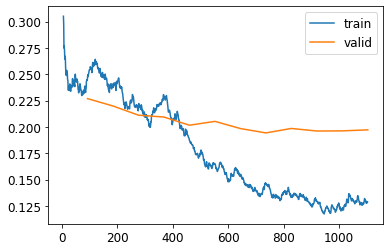

In [84]:
learn.recorder.plot_loss()

The other downside of deeper architectures is that they take quite a bit longer to train. One technique that can speed things up a lot is mixed-precision training. This refers to using less-precise numbers (half-precision floating point, also called fp16) where possible during training. As we are writing these words in early 2020, nearly all current NVIDIA GPUs support a special feature called tensor cores that can dramatically speed up neural network training, by 2-3x. They also require a lot less GPU memory. To enable this feature in fastai, just add to_fp16() after your Learner creation (you also need to import the module).

In [ ]:
#hide_output
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/jhoward/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_31.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x414
  Pipeline: partial -> Categorize
    starting from
      /home/jhoward/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_31.jpg
    applying partial gives
      american_pit_bull_terrier
    applying Categorize gives
      TensorCategory(13)

Final sample: (PILImage mode=RGB size=500x414, TensorCategory(13))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=500x414, TensorCategory(13))

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 414 and 375 in dimension 2 at /opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/TH/generic/THTensor.cpp:612

In [85]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.267878,0.309007,0.107578,00:29
1,0.589549,0.293300,0.087280,00:30
2,0.397278,0.293314,0.095399,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.267880,0.277450,0.081867,00:32
1,0.285513,0.344310,0.106901,00:32
2,0.251148,0.298109,0.079838,00:32
3,0.169477,0.253457,0.067659,00:32
4,0.088914,0.214855,0.063599,00:31
5,0.056139,0.209821,0.062246,00:32


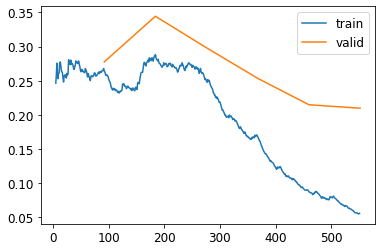

In [86]:
learn.recorder.plot_loss()

```
Setting-up type transforms pipelines
Collecting items from /home/sgugger/.fastai/data/oxford-iiit-pet/images
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/sgugger/.fastai/data/oxford-iiit-pet/images/american_bulldog_83.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize
    starting from
      /home/sgugger/.fastai/data/oxford-iiit-pet/images/american_bulldog_83.jpg
    applying partial gives
      american_bulldog
    applying Categorize gives
      TensorCategory(12)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(12))

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=375x500, TensorCategory(12))
    applying ToTensor gives
      (TensorImage of size 3x500x375, TensorCategory(12))

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch
Error! It's not possible to collate your items in a batch
Could not collate the 0-th members of your tuples because got the following 
shapes:
torch.Size([3, 500, 375]),torch.Size([3, 375, 500]),torch.Size([3, 333, 500]),
torch.Size([3, 375, 500])
```

You can see exactly how we gathered the data and split it, how we went from a filename to a *sample* (the tuple (image, category)), then what item transforms were applied and how it failed to collate those samples in a batch (because of the different shapes). 

Once you think your data looks right, we generally recommend the next step should be using it to train a simple model. We often see people put off the training of an actual model for far too long. As a result, they don't actually find out what their baseline results look like. Perhaps your problem doesn't need lots of fancy domain-specific engineering. Or perhaps the data doesn't seem to train the model at all. These are things that you want to know as soon as possible. For this initial test, we'll use the same simple model that we used in <<chapter_intro>>:

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.551305,0.322132,0.106225,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.529473,0.312148,0.095399,00:23
1,0.330207,0.245883,0.080514,00:24


As we've briefly discussed before, the table shown when we fit a model shows us the results after each epoch of training. Remember, an epoch is one complete pass through all of the images in the data. The columns shown are the average loss over the items of the training set, the loss on the validation set, and any metrics that we requested—in this case, the error rate.

Remember that *loss* is whatever function we've decided to use to optimize the parameters of our model. But we haven't actually told fastai what loss function we want to use. So what is it doing? fastai will generally try to select an appropriate loss function based on what kind of data and model you are using. In this case we have image data and a categorical outcome, so fastai will default to using *cross-entropy loss*.

*Cross-entropy loss* is a loss function that is similar to the one we used in the previous chapter, but (as we'll see) has two benefits:

- It works even when our dependent variable has more than two categories.
- It results in faster and more reliable training.

In order to understand how cross-entropy loss works for dependent variables with more than two categories, we first have to understand what the actual data and activations that are seen by the loss function look like.

### Viewing Activations and Labels

Let's take a look at the activations of our model. To actually get a batch of real data from our `DataLoaders`, we can use the `one_batch` method:

In [ ]:
x,y = dls.one_batch()

As you see, this returns the dependent and independent variables, as a mini-batch. Let's see what is actually contained in our dependent variable:

In [ ]:
y

TensorCategory([ 0,  5, 23, 36,  5, 20, 29, 34, 33, 32, 31, 24, 12, 36,  8, 26, 30,  2, 12, 17,  7, 23, 12, 29, 21,  4, 35, 33,  0, 20, 26, 30,  3,  6, 36,  2, 17, 32, 11,  6,  3, 30,  5, 26, 26, 29,  7, 36,
        31, 26, 26,  8, 13, 30, 11, 12, 36, 31, 34, 20, 15,  8,  8, 23], device='cuda:5')

Our batch size is 64, so we have 64 rows in this tensor. Each row is a single integer between 0 and 36, representing our 37 possible pet breeds. We can view the predictions (that is, the activations of the final layer of our neural network) using `Learner.get_preds`. This function either takes a dataset index (0 for train and 1 for valid) or an iterator of batches. Thus, we can pass it a simple list with our batch to get our predictions. It returns predictions and targets by default, but since we already have the targets, we can effectively ignore them by assigning to the special variable `_`:

In [ ]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([9.9911e-01, 5.0433e-05, 3.7515e-07, 8.8590e-07, 8.1794e-05, 1.8991e-05, 9.9280e-06, 5.4656e-07, 6.7920e-06, 2.3486e-04, 3.7872e-04, 2.0796e-05, 4.0443e-07, 1.6933e-07, 2.0502e-07, 3.1354e-08,
        9.4115e-08, 2.9782e-06, 2.0243e-07, 8.5262e-08, 1.0900e-07, 1.0175e-07, 4.4780e-09, 1.4285e-07, 1.0718e-07, 8.1411e-07, 3.6618e-07, 4.0950e-07, 3.8525e-08, 2.3660e-07, 5.3747e-08, 2.5448e-07,
        6.5860e-08, 8.0937e-05, 2.7464e-07, 5.6760e-07, 1.5462e-08])

The actual predictions are 37 probabilities between 0 and 1, which add up to 1 in total:

In [ ]:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

To transform the activations of our model into predictions like this, we used something called the *softmax* activation function.

### Softmax

In our classification model, we use the softmax activation function in the final layer to ensure that the activations are all between 0 and 1, and that they sum to 1.

Softmax is similar to the sigmoid function, which we saw earlier. As a reminder sigmoid looks like this:

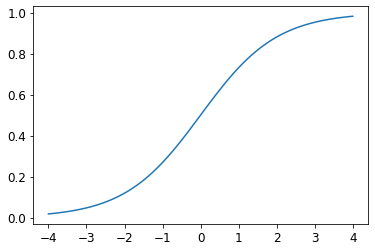

In [ ]:
plot_function(torch.sigmoid, min=-4,max=4)

We can apply this function to a single column of activations from a neural network, and get back a column of numbers between 0 and 1, so it's a very useful activation function for our final layer.

Now think about what happens if we want to have more categories in our target (such as our 37 pet breeds). That means we'll need more activations than just a single column: we need an activation *per category*. We can create, for instance, a neural net that predicts 3s and 7s that returns two activations, one for each class—this will be a good first step toward creating the more general approach. Let's just use some random numbers with a standard deviation of 2 (so we multiply `randn` by 2) for this example, assuming we have 6 images and 2 possible categories (where the first column represents 3s and the second is 7s):

In [ ]:
#hide
torch.random.manual_seed(42);

In [ ]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

We can't just take the sigmoid of this directly, since we don't get rows that add to 1 (i.e., we want the probability of being a 3 plus the probability of being a 7 to add up to 1):

In [ ]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In <<chapter_mnist_basics>>, our neural net created a single activation per image, which we passed through the `sigmoid` function. That single activation represented the model's confidence that the input was a 3. Binary problems are a special case of classification problems, because the target can be treated as a single boolean value, as we did in `mnist_loss`. But binary problems can also be thought of in the context of the more general group of classifiers with any number of categories: in this case, we happen to have two categories. As we saw in the bear classifier, our neural net will return one activation per category.

So in the binary case, what do those activations really indicate? A single pair of activations simply indicates the *relative* confidence of the input being a 3 versus being a 7. The overall values, whether they are both high, or both low, don't matter—all that matters is which is higher, and by how much.

We would expect that since this is just another way of representing the same problem, that we would be able to use `sigmoid` directly on the two-activation version of our neural net. And indeed we can! We can just take the *difference* between the neural net activations, because that reflects how much more sure we are of the input being a 3 than a 7, and then take the sigmoid of that:

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

The second column (the probability of it being a 7) will then just be that value subtracted from 1. Now, we need a way to do all this that also works for more than two columns. It turns out that this function, called `softmax`, is exactly that:

``` python
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```

> jargon: Exponential function (exp): Literally defined as `e**x`, where `e` is a special number approximately equal to 2.718. It is the inverse of the natural logarithm function. Note that `exp` is always positive, and it increases _very_ rapidly!

Let's check that `softmax` returns the same values as `sigmoid` for the first column, and those values subtracted from 1 for the second column:

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

`softmax` is the multi-category equivalent of `sigmoid`—we have to use it any time we have more than two categories and the probabilities of the categories must add to 1, and we often use it even when there are just two categories, just to make things a bit more consistent. We could create other functions that have the properties that all activations are between 0 and 1, and sum to 1; however, no other function has the same relationship to the sigmoid function, which we've seen is smooth and symmetric. Also, we'll see shortly that the softmax function works well hand-in-hand with the loss function we will look at in the next section.

If we have three output activations, such as in our bear classifier, calculating softmax for a single bear image would then look like something like <<bear_softmax>>.

<img alt="Bear softmax example" width="280" id="bear_softmax" caption="Example of softmax on the bear classifier" src="images/att_00062.png">

What does this function do in practice? Taking the exponential ensures all our numbers are positive, and then dividing by the sum ensures we are going to have a bunch of numbers that add up to 1. The exponential also has a nice property: if one of the numbers in our activations `x` is slightly bigger than the others, the exponential will amplify this (since it grows, well... exponentially), which means that in the softmax, that number will be closer to 1. 

Intuitively, the softmax function *really* wants to pick one class among the others, so it's ideal for training a classifier when we know each picture has a definite label. (Note that it may be less ideal during inference, as you might want your model to sometimes tell you it doesn't recognize any of the classes that it has seen during training, and not pick a class because it has a slightly bigger activation score. In this case, it might be better to train a model using multiple binary output columns, each using a sigmoid activation.)

Softmax is the first part of the cross-entropy loss—the second part is log likelihood. 

### Log Likelihood

When we calculated the loss for our MNIST example in the last chapter we used:

```python
def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()
```

Just as we moved from sigmoid to softmax, we need to extend the loss function to work with more than just binary classification—it needs to be able to classify any number of categories (in this case, we have 37 categories). Our activations, after softmax, are between 0 and 1, and sum to 1 for each row in the batch of predictions. Our targets are integers between 0 and 36.  Furthermore, cross-entropy loss generalizes our binary classification loss and allows for more than one correct label per example (which is called multi-label classificaiton, which we will discuss in Chapter 6).

In the binary case, we used `torch.where` to select between `inputs` and `1-inputs`. When we treat a binary classification as a general classification problem with two categories, it actually becomes even easier, because (as we saw in the previous section) we now have two columns, containing the equivalent of `inputs` and `1-inputs`. Since there is only one correct label per example, all we need to do is select the appropriate column (as opposed to multiplying multiple probabilities). Let's try to implement this in PyTorch. For our synthetic 3s and 7s example, let's say these are our labels:

In [ ]:
targ = tensor([0,1,0,1,1,0])

and these are the softmax activations:

In [ ]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

Then for each item of `targ` we can use that to select the appropriate column of `sm_acts` using tensor indexing, like so:

In [ ]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

To see exactly what's happening here, let's put all the columns together in a table. Here, the first two columns are our activations, then we have the targets and the row index.  We explain the last column, `result` below:

In [ ]:
#hide_input
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,result
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


Looking at this table, you can see that the `result` column can be calculated by taking the `targ` and `idx` columns as indices into the two-column matrix containing the `3` and `7` columns. That's what `sm_acts[idx, targ]` is actually doing.  The really interesting thing here is that this actually works just as well with more than two columns. To see this, consider what would happen if we added an activation column for every digit (0 through 9), and then `targ` contained a number from 0 to 9.

PyTorch provides a function that does exactly the same thing as `sm_acts[range(n), targ]` (except it takes the negative, because when applying the log afterward, we will have negative numbers), called `nll_loss` (*NLL* stands for *negative log likelihood*):

In [ ]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

Despite its name, this PyTorch function does not take the log. We'll see why in the next section, but first, let's see why taking the logarithm can be useful.

> warning: Confusing Name, Beware: The nll in `nll_loss` stands for "negative log likelihood," but it doesn't actually take the log at all! It assumes you have _already_ taken the log. PyTorch has a function called `log_softmax` that combines `log` and `softmax` in a fast and accurate way. `nll_loss` is designed to be used after `log_softmax`.

#### Taking the Log

Recall that cross entropy loss may involve the multiplication of many numbers.  Multiplying lots of negative numbers together can cause problems like [numerical underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) in computers.  Therefore, we want to transform these probabilities to larger values so we can perform mathematical operations on them.  There is a mathematical function that does exactly this: the *logarithm* (available as `torch.log`). It is not defined for numbers less than 0, and looks like this between 0 and 1:

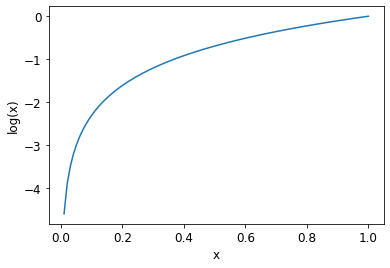

In [ ]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

Additionally, we want to ensure our model is able to detect differences between small numbers.  For example, consider the probabilities of .01 and .001.  Indeed, those numbers are very close together—but in another sense, 0.01 is 10 times more confident than 0.001.  By taking the log of our probabilities, we prevent these important differences from being ignored.

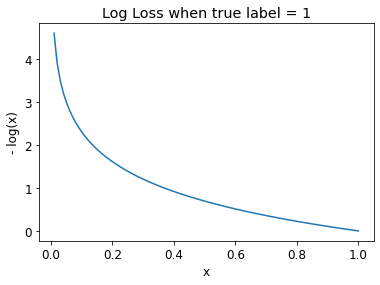

In [ ]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

Let's go ahead and update our previous table with an additional column, `loss` to reflect this loss function:

In [ ]:
#hide_input
from IPython.display import HTML
df['loss'] = -torch.log(tensor(df['result']))
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,result,loss
0.602469,0.397531,0,0,0.602469,0.506720
0.502065,0.497935,1,1,0.497935,0.697285
0.133188,0.866811,0,2,0.133188,2.015990
0.996640,0.003360,1,3,0.003360,5.695763
0.595949,0.404051,1,4,0.404051,0.906213
0.366118,0.633882,0,5,0.366118,1.004798


Notice how the loss is very large in the third and fourth rows where the predictions are confident and wrong, or in other words have high probabilities on the wrong class.  One benefit of using the log to calculate the loss is that our loss function penalizes predictions that are both confident and wrong.  This kind of penalty works well in practice to aid in more effective model training. 

We're calculating the loss from the column containing the correct label. Because there is only one "right" answer per example, we don't need to consider the other columns, because by the definition of softmax, they add up to 1 minus the activation corresponding to the correct label. As long as the activation columns sum to 1 (as they will, if we use softmax), then we'll have a loss function that shows how well we're predicting each digit.  Therefore, making the activation for the correct label as high as possible must mean we're also decreasing the activations of the remaining columns.  

### Negative Log Likelihood

Taking the mean of the negative log of our probabilities (taking the mean of the `loss` column of our table) gives us the *negative log likelihood* loss, which is another name for cross-entropy loss. Recall that PyTorch's `nll_loss` assumes that you already took the log of the softmax, so it doesn't actually do the logarithm for you.

When we first take the softmax, and then the log likelihood of that, that combination is called *cross-entropy loss*. In PyTorch, this is available as `nn.CrossEntropyLoss` (which, in practice, actually does `log_softmax` and then `nll_loss`):

In [ ]:
loss_func = nn.CrossEntropyLoss()

As you see, this is a class. Instantiating it gives you an object which behaves like a function:

In [ ]:
loss_func(acts, targ)

tensor(1.8045)

All PyTorch loss functions are provided in two forms, the class just shown above, and also a plain functional form, available in the `F` namespace:

In [ ]:
F.cross_entropy(acts, targ)

tensor(1.8045)

Either one works fine and can be used in any situation. We've noticed that most people tend to use the class version, and that's more often used in PyTorch's official docs and examples, so we'll tend to use that too.

By default PyTorch loss functions take the mean of the loss of all items. You can use `reduction='none'` to disable that:

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

You will notice these values match the `loss` column in our table exactly.

> s: An interesting feature about cross-entropy loss appears when we consider its gradient. The gradient of `cross_entropy(a,b)` is just `softmax(a)-b`. Since `softmax(a)` is just the final activation of the model, that means that the gradient is proportional to the difference between the prediction and the target. This is the same as mean squared error in regression (assuming there's no final activation function such as that added by `y_range`), since the gradient of `(a-b)**2` is `2*(a-b)`. Because the gradient is linear, that means we won't see sudden jumps or exponential increases in gradients, which should lead to smoother training of models.

We have now seen all the pieces hidden behind our loss function. But while this puts a number on how well (or badly) our model is doing, it does nothing to help us know if it's actually any good. Let's now see some ways to interpret our model's predictions.

It's very hard to interpret loss functions directly, because they are designed to be things computers can differentiate and optimize, not things that people can understand. That's why we have metrics. These are not used in the optimization process, but just to help us poor humans understand what's going on. In this case, our accuracy is looking pretty good already! So where are we making mistakes?

We saw in <<chapter_intro>> that we can use a confusion matrix to see where our model is doing well, and where it's doing badly:

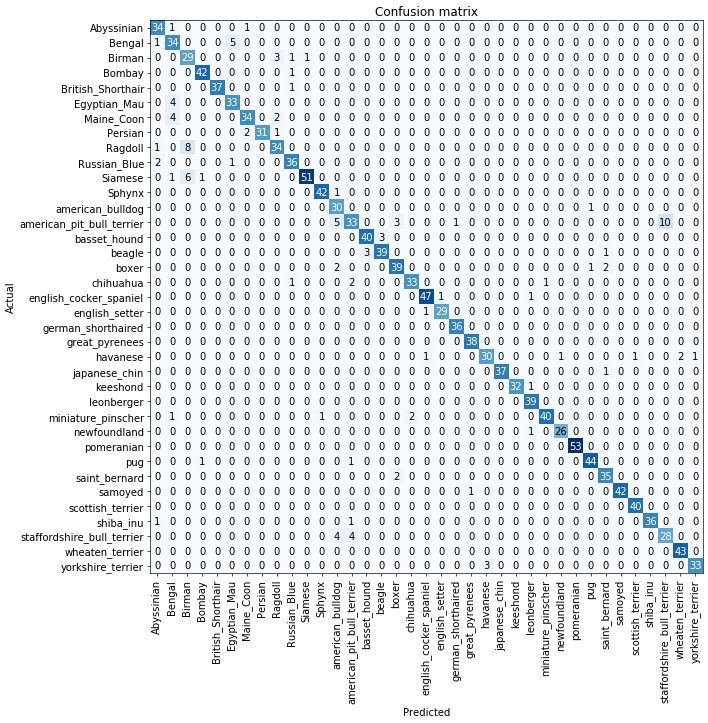

In [ ]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Oh dear—in this case, a confusion matrix is very hard to read. We have 37 different breeds of pet, which means we have 37×37 entries in this giant matrix! Instead, we can use the `most_confused` method, which just shows us the cells of the confusion matrix with the most incorrect predictions (here, with at least 5 or more):

In [ ]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('Ragdoll', 'Birman', 8),
 ('Siamese', 'Birman', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 5)]

Since we are not pet breed experts, it is hard for us to know whether these category errors reflect actual difficulties in recognizing breeds. So again, we turn to Google. A little bit of Googling tells us that the most common category errors shown here are actually breed differences that even expert breeders sometimes disagree about. So this gives us some comfort that we are on the right track.

We seem to have a good baseline. What can we do now to make it even better?

We will now look at a range of techniques to improve the training of our model and make it better. While doing so, we will explain a little bit more about transfer learning and how to fine-tune our pretrained model as best as possible, without breaking the pretrained weights.

The first thing we need to set when training a model is the learning rate. We saw in the previous chapter that it needs to be just right to train as efficiently as possible, so how do we pick a good one? fastai provides a tool for this.

### The Learning Rate Finder

One of the most important things we can do when training a model is to make sure that we have the right learning rate. If our learning rate is too low, it can take many, many epochs to train our model. Not only does this waste time, but it also means that we may have problems with overfitting, because every time we do a complete pass through the data, we give our model a chance to memorize it.

So let's just make our learning rate really high, right? Sure, let's try that and see what happens:

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.778816,5.150732,0.504060,00:20


epoch,train_loss,valid_loss,error_rate,time
0,4.354680,3.003533,0.834235,00:24


That doesn't look good. Here's what happened. The optimizer stepped in the correct direction, but it stepped so far that it totally overshot the minimum loss. Repeating that multiple times makes it get further and further away, not closer and closer!

What do we do to find the perfect learning rate—not too high, and not too low? In 2015 the researcher Leslie Smith came up with a brilliant idea, called the *learning rate finder*. His idea was to start with a very, very small learning rate, something so small that we would never expect it to be too big to handle. We use that for one mini-batch, find what the losses are afterwards, and then increase the learning rate by some percentage (e.g., doubling it each time). Then we do another mini-batch, track the loss, and double the learning rate again. We keep doing this until the loss gets worse, instead of better. This is the point where we know we have gone too far. We then select a learning rate a bit lower than this point. Our advice is to pick either:

- One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
- The last point where the loss was clearly decreasing 

The learning rate finder computes those points on the curve to help you. Both these rules usually give around the same value. In the first chapter, we didn't specify a learning rate, using the default value from the fastai library (which is 1e-3):

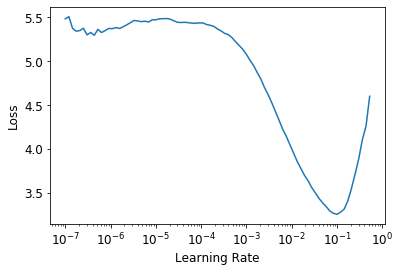

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 5.25e-03


We can see on this plot that in the range 1e-6 to 1e-3, nothing really happens and the model doesn't train. Then the loss starts to decrease until it reaches a minimum, and then increases again. We don't want a learning rate greater than 1e-1 as it will give a training that diverges like the one before (you can try for yourself), but 1e-1 is already too high: at this stage we've left the period where the loss was decreasing steadily.

In this learning rate plot it appears that a learning rate around 3e-3 would be appropriate, so let's choose that:

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.328591,0.344678,0.114344,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.540180,0.420945,0.127876,00:24
1,0.329827,0.248813,0.083221,00:24


> Note: Logarithmic Scale: The learning rate finder plot has a logarithmic scale, which is why the middle point between 1e-3 and 1e-2 is between 3e-3 and 4e-3. This is because we care mostly about the order of magnitude of the learning rate.

It's interesting that the learning rate finder was only discovered in 2015, while neural networks have been under development since the 1950s. Throughout that time finding a good learning rate has been, perhaps, the most important and challenging issue for practitioners. The solution does not require any advanced maths, giant computing resources, huge datasets, or anything else that would make it inaccessible to any curious researcher. Furthermore, Leslie Smith, was not part of some exclusive Silicon Valley lab, but was working as a naval researcher. All of this is to say: breakthrough work in deep learning absolutely does not require access to vast resources, elite teams, or advanced mathematical ideas. There is lots of work still to be done that requires just a bit of common sense, creativity, and tenacity.

Now that we have a good learning rate to train our model, let's look at how we can fine-tune the weights of a pretrained model.

### Unfreezing and Transfer Learning

When we create a model from a pretrained network fastai automatically freezes all of the pretrained layers for us. When we call the `fine_tune` method fastai does two things:

- Trains the randomly added layers for one epoch, with all other layers frozen
- Unfreezes all of the layers, and trains them all for the number of epochs requested

Although this is a reasonable default approach, it is likely that for your particular dataset you may get better results by doing things slightly differently. The `fine_tune` method has a number of parameters you can use to change its behavior, but it might be easiest for you to just call the underlying methods directly if you want to get some custom behavior. Remember that you can see the source code for the method by using the following syntax:

    learn.fine_tune??

So let's try doing this manually ourselves. First of all we will train the randomly added layers for three epochs, using `fit_one_cycle`. As mentioned in <<chapter_intro>>, `fit_one_cycle` is the suggested way to train models without using `fine_tune`. We'll see why later in the book; in short, what `fit_one_cycle` does is to start training at a low learning rate, gradually increase it for the first section of training, and then gradually decrease it again for the last section of training.

In [ ]:
learn.fine_tune??

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.188042,0.355024,0.102842,00:20
1,0.534234,0.302453,0.094723,00:20
2,0.325031,0.222268,0.074425,00:20


Then we'll unfreeze the model:

In [ ]:
learn.unfreeze()

and run `lr_find` again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more:

(1.0964782268274575e-05, 1.5848931980144698e-06)

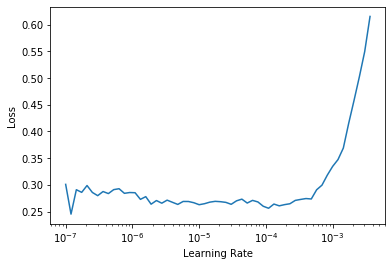

In [ ]:
learn.lr_find()

Note that the graph is a little different from when we had random weights: we don't have that sharp descent that indicates the model is training. That's because our model has been trained already. Here we have a somewhat flat area before a sharp increase, and we should take a point well before that sharp increase—for instance, 1e-5. The point with the maximum gradient isn't what we look for here and should be ignored.

Let's train at a suitable learning rate:

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.263579,0.217419,0.069012,00:24
1,0.253060,0.210346,0.062923,00:24
2,0.224340,0.207357,0.060217,00:24
3,0.200195,0.207244,0.061570,00:24
4,0.194269,0.200149,0.059540,00:25
5,0.173164,0.202301,0.059540,00:25


This has improved our model a bit, but there's more we can do. The deepest layers of our pretrained model might not need as high a learning rate as the last ones, so we should probably use different learning rates for those—this is known as using *discriminative learning rates*.

### Discriminative Learning Rates

Even after we unfreeze, we still care a lot about the quality of those pretrained weights. We would not expect that the best learning rate for those pretrained parameters would be as high as for the randomly added parameters, even after we have tuned those randomly added parameters for a few epochs. Remember, the pretrained weights have been trained for hundreds of epochs, on millions of images.

In addition, do you remember the images we saw in <<chapter_intro>>, showing what each layer learns? The first layer learns very simple foundations, like edge and gradient detectors; these are likely to be just as useful for nearly any task. The later layers learn much more complex concepts, like "eye" and "sunset," which might not be useful in your task at all (maybe you're classifying car models, for instance). So it makes sense to let the later layers fine-tune more quickly than earlier layers.

Therefore, fastai's default approach is to use discriminative learning rates. This was originally developed in the ULMFiT approach to NLP transfer learning that we will introduce in <<chapter_nlp>>. Like many good ideas in deep learning, it is extremely simple: use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers (and especially the randomly added layers). The idea is based on insights developed by [Jason Yosinski](https://arxiv.org/abs/1411.1792), who showed in 2014 that with transfer learning different layers of a neural network should train at different speeds, as seen in <<yosinski>>.

<img alt="Impact of different layers and training methods on transfer learning (Yosinski)" width="680" caption="Impact of different layers and training methods on transfer learning (courtesy of Jason Yosinski et al.)" id="yosinski" src="images/att_00039.png">

fastai lets you pass a Python `slice` object anywhere that a learning rate is expected. The first value passed will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range. Let's use this approach to replicate the previous training, but this time we'll only set the *lowest* layer of our net to a learning rate of 1e-6; the other layers will scale up to 1e-4. Let's train for a while and see what happens:

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.145300,0.345568,0.119756,00:20
1,0.533986,0.251944,0.077131,00:20
2,0.317696,0.208371,0.069012,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.257977,0.205400,0.067659,00:25
1,0.246763,0.205107,0.066306,00:25
2,0.240595,0.193848,0.062246,00:25
3,0.209988,0.198061,0.062923,00:25
4,0.194756,0.193130,0.064276,00:25
5,0.169985,0.187885,0.056157,00:25
6,0.153205,0.186145,0.058863,00:25
7,0.141480,0.185316,0.053451,00:25
8,0.128564,0.180999,0.051421,00:25
9,0.126941,0.186288,0.054127,00:25


Now the fine-tuning is working great!

fastai can show us a graph of the training and validation loss:

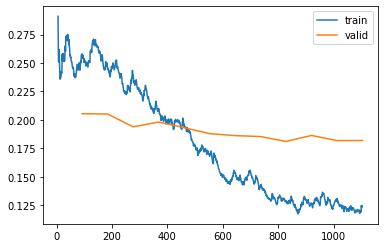

In [ ]:
learn.recorder.plot_loss()

As you can see, the training loss keeps getting better and better. But notice that eventually the validation loss improvement slows, and sometimes even gets worse! This is the point at which the model is starting to over fit. In particular, the model is becoming overconfident of its predictions. But this does *not* mean that it is getting less accurate, necessarily. Take a look at the table of training results per epoch, and you will often see that the accuracy continues improving, even as the validation loss gets worse. In the end what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we've given the computer to help us to optimize.

### Deeper Architectures

In [ ]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.427505,0.310554,0.098782,00:21
1,0.606785,0.302325,0.094723,00:22
2,0.409267,0.294803,0.091340,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.261121,0.274507,0.083897,00:26
1,0.296653,0.318649,0.084574,00:26
2,0.242356,0.253677,0.069012,00:26
3,0.150684,0.251438,0.065629,00:26
4,0.094997,0.239772,0.064276,00:26
5,0.061144,0.228082,0.054804,00:26


You'll see here we've gone back to using `fine_tune`, since it's so handy! We can pass `freeze_epochs` to tell fastai how many epochs to train for while frozen. It will automatically change learning rates appropriately for most datasets.

In this case, we're not seeing a clear win from the deeper model. This is useful to remember—bigger models aren't necessarily better models for your particular case! Make sure you try small models before you start scaling up.